In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

pd.set_option("display.max_rows", None)

In [3]:
# define column names as defined by the NASA instructions

def load_cmapss_data(train_path, test_path, rul_path, include_sensor_desc = False):

    #Sensor column descriptions
    description_headers = ["Temp, fan in", "Temp, LPC out", "Temp, HPC out", 
                           "Temp, LPT out", "Press, fan in", "Tot Press, bypass", "Tot Press, HPC out",
                           "Speed, fan", "Speed, core", "Eng Press Ratio", "Stat Press, HPC out", 
                           "phi Fuel Flow Ratio", "Corr. Speed, Fan", "Corr. Speed, Core", "Bypass Ratio", 
                           "Burner Fuel/Air Ratio", "Bleed Enthalpy", "Dem Speed, fan", "(?) Dem Corr Speed, fan", 
                           "Coolant Bleed, HPT", "Coolant Bleed, LPT" ]
    #Temps are in R; for temps in F, subtract 459.67
    #Pressures are in psia
    #Speed is in rpm
    #"phi Fuel Flow Ratio" is ration of fuel flow to static pressure at HPC, in pps/psi
    #Bypass ratio - proportion of air mass passing through bypass versus the engine core (compressors/burners/turbines)
    #"Bleed Enthalpy" refers to bleed air (?), and the total enthalpy of it (Enthalpy = Internal Energy + (Pressure*Volume))
    #Coolant Bleed is in pound mass per second (lbm/s)
    
    # apply the unit number and the time (in cycles)
    index_names = ['unit_number', 'time_cycles']
    
    # there are three operational settings that are utilized by the engine 
    setting_names = ['setting_1', 'setting_2', 'setting_3']

    # add sensor numbers to the sensors
    sensor_names = ['sensor_{}'.format(i) for i in range(1, 22)]
    
    # join the index, setting and sensor column names to then apply to the txt files
    if include_sensor_desc == False:
        col_names = index_names + setting_names + sensor_names
    else:
        col_names = index_names + setting_names + description_headers
    
    # read txt data and apply the above 
    train = pd.read_csv(train_path, sep='\s+', header=None, names=col_names)
    test = pd.read_csv(test_path, sep='\s+', header=None, names=col_names)
    y_test = pd.read_csv(rul_path, sep='\s+', header=None, names=['RUL'])
    
    return train, test, y_test

In [4]:
# Data Set: FD001
# Train trjectories: 100
# Test trajectories: 100
# Conditions: ONE (Sea Level)
# Fault Modes: ONE (HPC Degradation)

# reading in the first dataset since it is a dataset that has one condition and one fault, and will allow us to make a relatively easier model
# that can then be built upon in complexity in the second stage of the analysis 

pd.set_option('display.max_columns', None)
train, test, y_test = load_cmapss_data('CMAPSSData/train_FD001.txt', 
                                       'CMAPSSData/test_FD001.txt', 
                                       'CMAPSSData/RUL_FD001.txt', 
                                       include_sensor_desc = True)

In [5]:
train.head()

,unit_number,time_cycles,setting_1,setting_2,setting_3,"Temp, fan in","Temp, LPC out","Temp, HPC out","Temp, LPT out","Press, fan in","Tot Press, bypass","Tot Press, HPC out","Speed, fan","Speed, core",Eng Press Ratio,"Stat Press, HPC out",phi Fuel Flow Ratio,"Corr. Speed, Fan","Corr. Speed, Core",Bypass Ratio,Burner Fuel/Air Ratio,Bleed Enthalpy,"Dem Speed, fan","(?) Dem Corr Speed, fan","Coolant Bleed, HPT","Coolant Bleed, LPT"
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [6]:
# to get the number of unique engines in the dataset we can look at the number of unique numbers in the first column
len(np.unique(train["unit_number"]))

100

In [7]:
# the number of cycles it took for each of these engines to fail 
num_cycles_to_failure = train.groupby("unit_number")["time_cycles"].count()
num_cycles_to_failure.values

array([192, 287, 179, 189, 269, 188, 259, 150, 201, 222, 240, 170, 163,
       180, 207, 209, 276, 195, 158, 234, 195, 202, 168, 147, 230, 199,
       156, 165, 163, 194, 234, 191, 200, 195, 181, 158, 170, 194, 128,
       188, 216, 196, 207, 192, 158, 256, 214, 231, 215, 198, 213, 213,
       195, 257, 193, 275, 137, 147, 231, 172, 185, 180, 174, 283, 153,
       202, 313, 199, 362, 137, 208, 213, 213, 166, 229, 210, 154, 231,
       199, 185, 240, 214, 293, 267, 188, 278, 178, 213, 217, 154, 135,
       341, 155, 258, 283, 336, 202, 156, 185, 200])

In [8]:
train.describe()

,unit_number,time_cycles,setting_1,setting_2,setting_3,"Temp, fan in","Temp, LPC out","Temp, HPC out","Temp, LPT out","Press, fan in","Tot Press, bypass","Tot Press, HPC out","Speed, fan","Speed, core",Eng Press Ratio,"Stat Press, HPC out",phi Fuel Flow Ratio,"Corr. Speed, Fan","Corr. Speed, Core",Bypass Ratio,Burner Fuel/Air Ratio,Bleed Enthalpy,"Dem Speed, fan","(?) Dem Corr Speed, fan","Coolant Bleed, HPT","Coolant Bleed, LPT"
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,553.367711,2388.096652,9065.242941,1.3,47.541168,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,0.001389,0.885092,0.070985,22.082880,0.0,0.267087,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,2387.900000,9021.730000,1.3,46.850000,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,552.810000,2388.050000,9053.100000,1.3,47.350000,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,553.440000,2388.090000,9060.660000,1.3,47.510000,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,554.010000,2388.140000,9069.420000,1.3,47.700000,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000,2388.560000,9244.590000,1.3,48.530000,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [9]:
def drop_constant_value(df, include_printout = True):
    # identify the columns where the value is constant throughout (hence obsolete)
    constant_columns = [col for col in df.columns if df[col].nunique() == 1]
    
    if include_printout:
        print("Columns Dropped: ")
        for col in constant_columns:
            print(col)
    
    # drop them
    return df.drop(columns=constant_columns)

# drop them in the train
train = drop_constant_value(train)

# check the shape of the train dataset
train.shape


Columns Dropped: 
setting_3
Temp, fan in
Press, fan in
Eng Press Ratio
Burner Fuel/Air Ratio
Dem Speed, fan
(?) Dem Corr Speed, fan


(20631, 19)

In [10]:
def add_remaining_useful_life(df):
    # get the max cycle for each unit (100 units)
    max_cycle = df.groupby("unit_number")["time_cycles"].transform('max')
    
    # compute the RUL for each unit row by row till it hits 0
    df["RUL"] = max_cycle - df["time_cycles"]
    
    return df

# apply function
train = add_remaining_useful_life(train)

train.tail(15)

,unit_number,time_cycles,setting_1,setting_2,"Temp, LPC out","Temp, HPC out","Temp, LPT out","Tot Press, bypass","Tot Press, HPC out","Speed, fan","Speed, core","Stat Press, HPC out",phi Fuel Flow Ratio,"Corr. Speed, Fan","Corr. Speed, Core",Bypass Ratio,Bleed Enthalpy,"Coolant Bleed, HPT","Coolant Bleed, LPT",RUL
20616,100,186,0.0026,0.0004,643.61,1593.55,1425.32,21.61,552.28,2388.20,9066.46,48.06,520.66,2388.27,8138.08,8.4735,394,38.51,23.1173,14
20617,100,187,0.0015,0.0002,643.63,1596.96,1421.49,21.61,551.53,2388.22,9065.94,48.04,520.15,2388.22,8140.49,8.5087,396,38.67,23.2308,13
20618,100,188,-0.0008,-0.0002,643.19,1597.77,1426.57,21.61,550.77,2388.26,9067.68,48.29,519.98,2388.21,8139.94,8.4814,395,38.36,23.0552,12
20619,100,189,0.0015,0.0001,643.69,1599.85,1423.15,21.61,551.61,2388.18,9069.69,47.99,519.50,2388.24,8139.78,8.4870,397,38.65,23.0591,11
20620,100,190,-0.0001,0.0002,643.12,1594.45,1426.04,21.61,551.06,2388.21,9064.74,47.99,519.52,2388.26,8142.28,8.5162,395,38.42,23.0603,10
20621,100,191,-0.0005,-0.0000,643.69,1610.87,1427.19,21.61,551.78,2388.26,9068.90,48.07,519.80,2388.28,8143.56,8.5092,398,38.39,23.1218,9
20622,100,192,-0.0009,0.0001,643.53,1601.23,1419.48,21.61,551.14,2388.17,9060.45,48.18,520.59,2388.21,8143.46,8.4892,397,38.56,23.0770,8
20623,100,193,-0.0001,0.0002,643.09,1599.81,1428.93,21.61,552.04,2388.29,9067.57,48.19,520.11,2388.19,8142.02,8.5424,397,38.47,23.0230,7
20624,100,194,-0.0011,0.0003,643.72,1597.29,1427.41,21.61,551.99,2388.23,9068.85,48.12,519.55,2388.22,8139.67,8.5215,394,38.38,23.1324,6
20625,100,195,-0.0002,-0.0001,643.41,1600.04,1431.90,21.61,551.42,2388.23,9069.69,48.22,519.71,2388.28,8142.90,8.5519,394,38.14,23.1923,5


In [11]:
def create_test_train_split(train_set, test_set, ratio_train = .8, random_seed = None, split_field = 'unit_number'):
    """
    Assumes that target variable is already included in test set.
    """
    
    #Set random seed for reproduction
    random.seed(random_seed)
    
    #Randomly designate each engine to a train or test set.
    num = int(len(train_set[split_field].unique()) * ratio_train)
    engine_set = list(train_set[split_field].unique())
    train_engines = set(random.sample(engine_set, num))
    test_engines = set(engine_set) - train_engines
    
    #Screen input DF's to seperate engines intended for train and testing. 
    screened_test_set = test_set[test_set[split_field].isin(test_engines)]
    screened_train_set = train_set[train_set[split_field].isin(train_engines)]
    
#     print(test_engines)
#     print(train_engines)
    
    return screened_train_set, screened_test_set

In [12]:
tr, te = create_test_train_split(train, test)
display(tr.sample(5))
display(te.sample(5))
del tr, te

,unit_number,time_cycles,setting_1,setting_2,"Temp, LPC out","Temp, HPC out","Temp, LPT out","Tot Press, bypass","Tot Press, HPC out","Speed, fan","Speed, core","Stat Press, HPC out",phi Fuel Flow Ratio,"Corr. Speed, Fan","Corr. Speed, Core",Bypass Ratio,Bleed Enthalpy,"Coolant Bleed, HPT","Coolant Bleed, LPT",RUL
3670,18,90,-0.0008,0.0003,642.74,1586.97,1392.63,21.61,554.97,2388.03,9070.39,47.30,522.07,2388.06,8149.48,8.4299,393,38.66,23.3423,105
4659,23,95,-0.0008,-0.0002,642.65,1596.54,1414.12,21.61,552.83,2388.14,9054.50,47.80,521.44,2388.09,8131.68,8.4662,393,38.85,23.2618,73
6706,34,95,0.0013,-0.0003,643.00,1589.67,1405.43,21.61,553.95,2388.00,9064.19,47.43,521.45,2388.09,8146.89,8.4370,393,38.82,23.3666,100
6152,31,166,0.0019,0.0002,643.10,1588.23,1409.64,21.61,553.54,2388.08,9046.73,47.45,521.86,2388.07,8133.37,8.4267,394,38.99,23.3332,68
2881,14,173,0.0040,0.0003,644.09,1603.45,1423.90,21.61,551.64,2388.18,9123.75,48.05,520.20,2388.19,8193.66,8.5031,396,38.61,23.0647,7


,unit_number,time_cycles,setting_1,setting_2,setting_3,"Temp, fan in","Temp, LPC out","Temp, HPC out","Temp, LPT out","Press, fan in","Tot Press, bypass","Tot Press, HPC out","Speed, fan","Speed, core",Eng Press Ratio,"Stat Press, HPC out",phi Fuel Flow Ratio,"Corr. Speed, Fan","Corr. Speed, Core",Bypass Ratio,Burner Fuel/Air Ratio,Bleed Enthalpy,"Dem Speed, fan","(?) Dem Corr Speed, fan","Coolant Bleed, HPT","Coolant Bleed, LPT"
7842,61,60,-0.0012,-0.0004,100.0,518.67,642.33,1587.06,1404.80,14.62,21.61,554.82,2388.03,9070.17,1.3,47.20,522.13,2387.99,8148.14,8.4201,0.03,392,2388,100.0,38.99,23.2653
3204,28,3,-0.0015,0.0003,100.0,518.67,642.62,1586.58,1413.18,14.62,21.61,553.86,2388.10,9042.65,1.3,47.28,521.73,2388.05,8131.81,8.4129,0.03,391,2388,100.0,38.91,23.2566
7943,62,2,0.0006,-0.0000,100.0,518.67,642.33,1579.35,1393.61,14.62,21.60,553.94,2387.97,9056.41,1.3,47.18,522.00,2387.99,8133.43,8.3864,0.03,391,2388,100.0,39.01,23.4976
5797,46,133,0.0012,0.0001,100.0,518.67,643.28,1590.14,1404.31,14.62,21.61,553.62,2388.18,9076.83,1.3,47.63,521.70,2388.12,8154.27,8.4978,0.03,395,2388,100.0,38.68,23.2661
2147,19,32,0.0011,-0.0004,100.0,518.67,642.57,1592.03,1399.92,14.62,21.61,554.52,2388.00,9057.07,1.3,47.23,521.86,2388.05,8134.31,8.4285,0.03,391,2388,100.0,38.90,23.3837


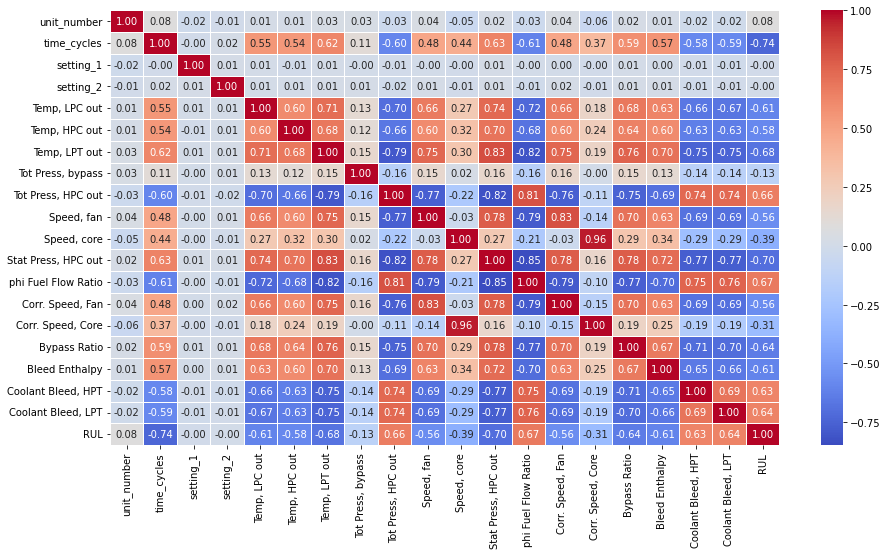

In [13]:
def get_corr_matrix(df):
    
    """
    Does not return an object. Displays correlation matrix only. 
    Uses Pearson's coefficient, which is already normalized.
    """
    
    # make corr matrix 
    corr_matrix = df.corr()

    # plot heatmap for corr matrix 
    plt.figure(figsize=(15, 8)) 
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

    # Show the plot
    plt.show()
    
    return None

get_corr_matrix(train)

In [14]:
def drop_highly_correlated_features(df, threshold=0.95, include_printout = False):

    # get the absolute corr matrix
    corr_matrix = df.corr().abs()

    # iterate through each col and find the one with the highest correlations
    to_drop = set()  
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] > threshold:
                if include_printout:
                    print("High correlation exists between (", corr_matrix.columns[i], ") and (", corr_matrix.columns[j], ").")
                    print("     Dropped (", corr_matrix.columns[i], ").\n")
                colname = corr_matrix.columns[i]
                to_drop.add(colname)

    # drop the col that has highest correlations 
    df = df.drop(columns=to_drop)

    print(to_drop)

    return df

# call function
tr = train.copy()
drop_highly_correlated_features(tr, include_printout = True)
del tr

High correlation exists between ( Corr. Speed, Core ) and ( Speed, core ).
     Dropped ( Corr. Speed, Core ).

{'Corr. Speed, Core'}


In [15]:
# call function
train = drop_highly_correlated_features(train)

{'Corr. Speed, Core'}


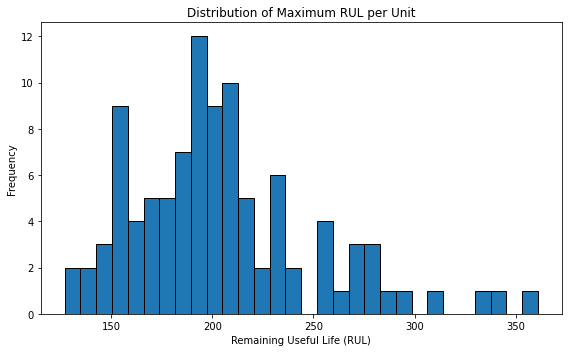

In [16]:

# get the maximum RUL for each unit 
df_max_rul = train.groupby('unit_number')['RUL'].max().reset_index()

# plot historgram
plt.figure(figsize=(8, 5)) 
plt.hist(df_max_rul['RUL'], bins=30, edgecolor='black')

# labels and title
plt.xlabel('Remaining Useful Life (RUL)')
plt.ylabel('Frequency')
plt.title('Distribution of Maximum RUL per Unit')

plt.tight_layout() 
plt.show()


In [17]:
train.head()

,unit_number,time_cycles,setting_1,setting_2,"Temp, LPC out","Temp, HPC out","Temp, LPT out","Tot Press, bypass","Tot Press, HPC out","Speed, fan","Speed, core","Stat Press, HPC out",phi Fuel Flow Ratio,"Corr. Speed, Fan",Bypass Ratio,Bleed Enthalpy,"Coolant Bleed, HPT","Coolant Bleed, LPT",RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187


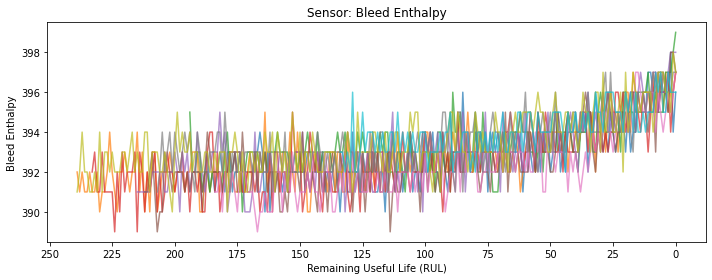

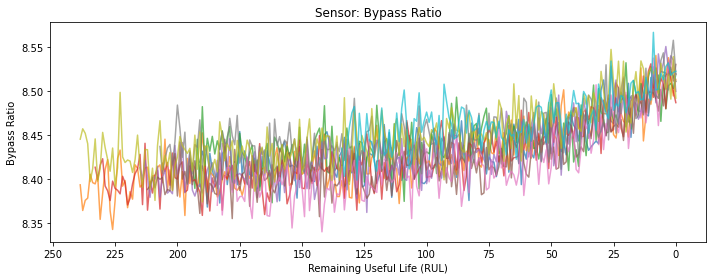

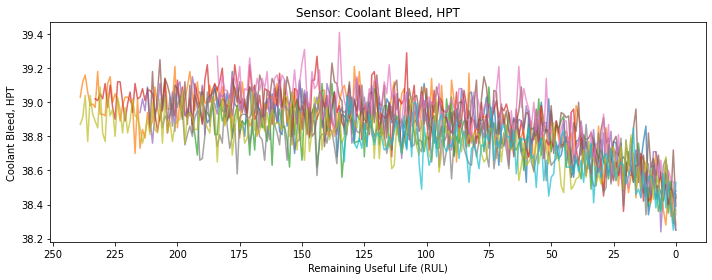

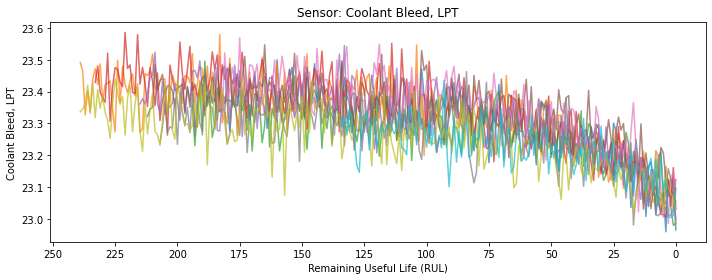

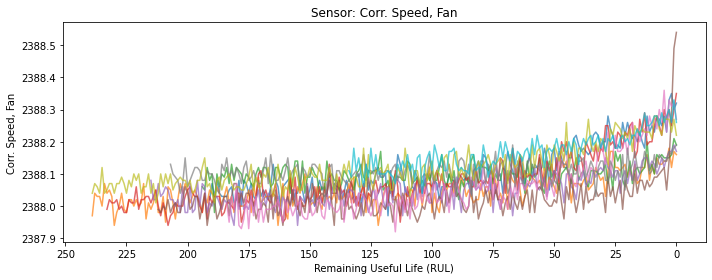

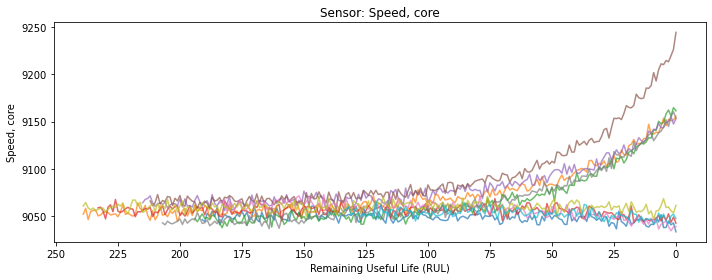

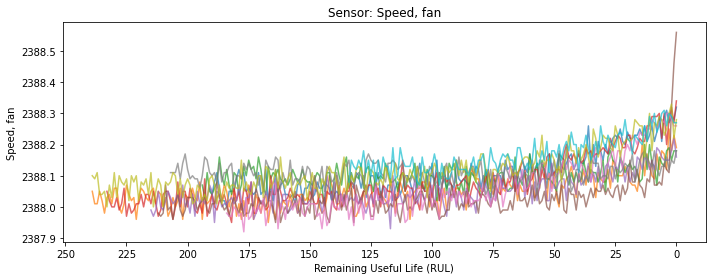

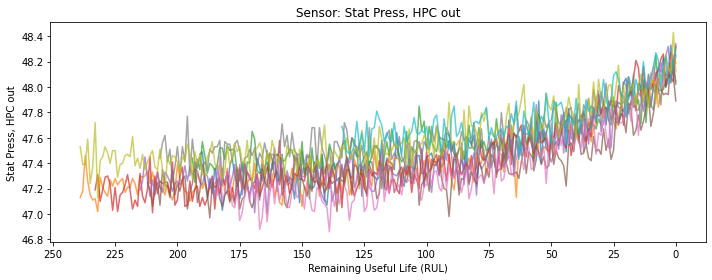

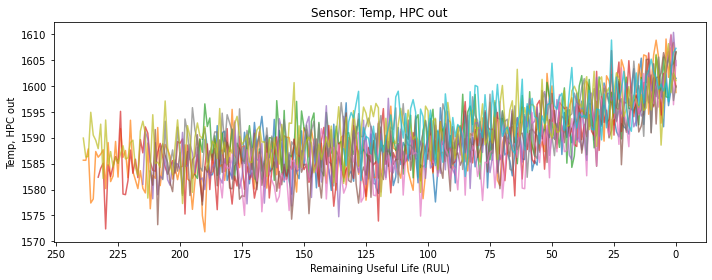

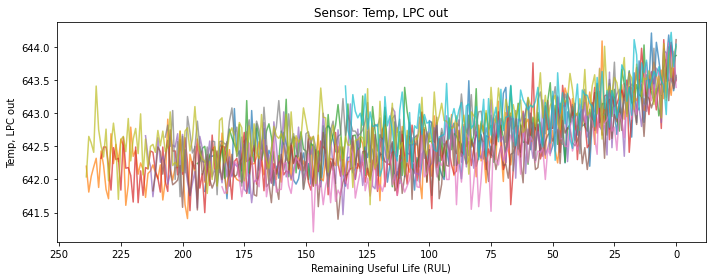

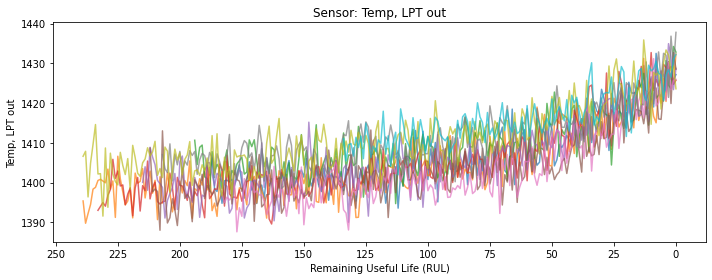

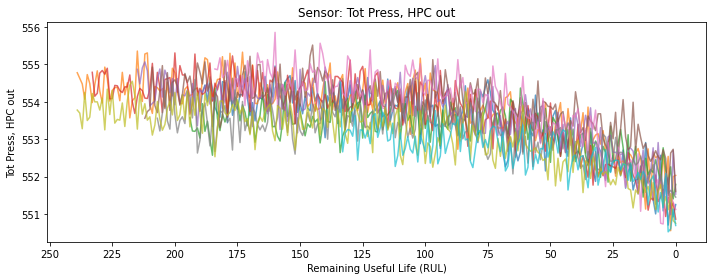

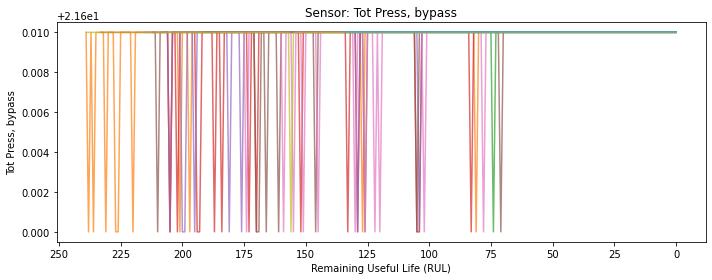

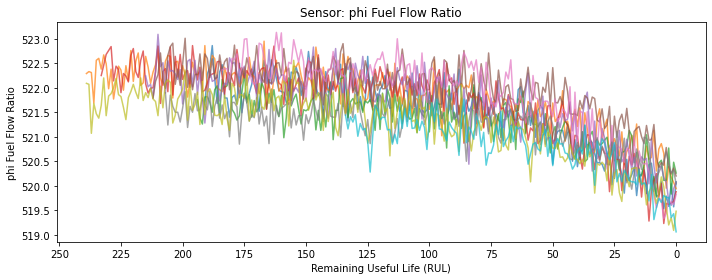

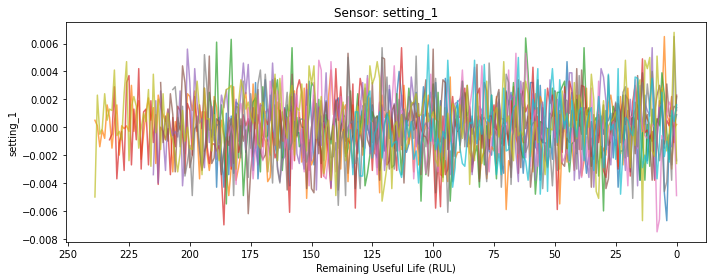

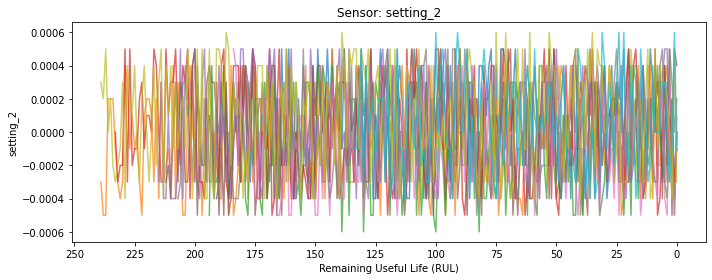

In [18]:
# plot the sensors individually against the RUL 
def plot_sensors(train, step=10):

    # find the sensor cols all which have a number in them and excluse unit_number and rul
    sensor_cols = train.columns.difference(['unit_number', 'RUL', 'time_cycles'])

    for sensor in sensor_cols:
        plt.figure(figsize=(10, 4))
        
        # plot for every nth unit (10th, 20th, 30th ... etc)
        for unit in train['unit_number'].unique()[::step]:
            plt.plot(train[train['unit_number'] == unit]['RUL'], 
                     train[train['unit_number'] == unit][sensor], 
                     label=f'Unit {unit}', alpha=0.7)
        
        plt.gca().invert_xaxis()  # reverse the x axis so that RUL is decreasing
        plt.xticks(np.arange(0, 275, 25))
        plt.ylabel(sensor)
        plt.xlabel('Remaining Useful Life (RUL)')
        plt.title(f'Sensor: {sensor}')
        plt.tight_layout()
        plt.show()

# Call the function to plot all sensors
plot_sensors(train)


In [19]:
train.head()

,unit_number,time_cycles,setting_1,setting_2,"Temp, LPC out","Temp, HPC out","Temp, LPT out","Tot Press, bypass","Tot Press, HPC out","Speed, fan","Speed, core","Stat Press, HPC out",phi Fuel Flow Ratio,"Corr. Speed, Fan",Bypass Ratio,Bleed Enthalpy,"Coolant Bleed, HPT","Coolant Bleed, LPT",RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187


In [20]:
# we see that there are some settings/sensors that do not have much patterns when mapped against RUL. let's find them. 

def drop_low_correlation_features(df, target_column='RUL', threshold=0.1, exclude_columns=None, include_printout = False):

    # exclude specified columns
    if exclude_columns is None:
        exclude_columns = []

    # get corr matrix
    corr_matrix = df.drop(columns=exclude_columns).corr()

    # get corr matrix against target col
    correlations = corr_matrix[target_column]

    # get features with correlations lower than the threshold
    low_correlation_features = correlations[correlations.abs() < threshold].index.tolist()
    
    if include_printout:
        print("Features being dropped: ")
        for item in low_correlation_features:
            print(item)

    # drop those with less than the threshold correlations
    df = df.drop(columns=low_correlation_features)

    return df

train = drop_low_correlation_features(train, threshold=0.1, 
                                      exclude_columns=['unit_number', 'time_cycles'], 
                                      include_printout = True)

train.head()



Features being dropped: 
setting_1
setting_2


,unit_number,time_cycles,"Temp, LPC out","Temp, HPC out","Temp, LPT out","Tot Press, bypass","Tot Press, HPC out","Speed, fan","Speed, core","Stat Press, HPC out",phi Fuel Flow Ratio,"Corr. Speed, Fan",Bypass Ratio,Bleed Enthalpy,"Coolant Bleed, HPT","Coolant Bleed, LPT",RUL
0,1,1,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,1,2,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,1,3,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,1,4,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,1,5,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187


In [21]:
print(train.columns)

Index(['unit_number', 'time_cycles', 'Temp, LPC out', 'Temp, HPC out',
       'Temp, LPT out', 'Tot Press, bypass', 'Tot Press, HPC out',
       'Speed, fan', 'Speed, core', 'Stat Press, HPC out',
       'phi Fuel Flow Ratio', 'Corr. Speed, Fan', 'Bypass Ratio',
       'Bleed Enthalpy', 'Coolant Bleed, HPT', 'Coolant Bleed, LPT', 'RUL'],
      dtype='object')


In [23]:
df = train[['unit_number', 'time_cycles', 'Temp, LPC out', 'Temp, HPC out',
       'Temp, LPT out', 'Tot Press, bypass', 'Tot Press, HPC out']]
df = df[df['unit_number'].isin([1, 2, 3, 4, 5])]
df

,unit_number,time_cycles,"Temp, LPC out","Temp, HPC out","Temp, LPT out","Tot Press, bypass","Tot Press, HPC out"
0,1,1,641.82,1589.70,1400.60,21.61,554.36
1,1,2,642.15,1591.82,1403.14,21.61,553.75
2,1,3,642.35,1587.99,1404.20,21.61,554.26
3,1,4,642.35,1582.79,1401.87,21.61,554.45
4,1,5,642.37,1582.85,1406.22,21.61,554.00
5,1,6,642.10,1584.47,1398.37,21.61,554.67
6,1,7,642.48,1592.32,1397.77,21.61,554.34
7,1,8,642.56,1582.96,1400.97,21.61,553.85
8,1,9,642.12,1590.98,1394.80,21.61,553.69
9,1,10,641.71,1591.24,1400.46,21.61,553.59


In [24]:
#df.rolling(window = 3, min_periods = 1, axis = 0).mean()

In [32]:
def get_rolling_averages(df, 
                         num_cycles = 5, 
                         drop_original = True, 
                         exclude_cols = ['unit_number', 'time_cycles', 'setting_1', 'setting_2', 'setting_3']):
    
    cols = list(set(df.columns) - set(exclude_cols))
    units = df['unit_number'].unique()
    
    print(cols)
    print(units)
    
    for unit in units:
        for col in cols:
            df[df['unit_number'] == unit] = df[df['unit_number'] == unit].rolling(window=num_cycles, min_periods = 1, on = col).mean()

    display(df)
    return None
            
get_rolling_averages(df)
            

['Tot Press, bypass', 'Temp, HPC out', 'Temp, LPT out', 'Temp, LPC out', 'Tot Press, HPC out']
[1 2 3 4 5]


C:\Users\sbmoi\AppData\Local\Temp\ipykernel_31484\371692245.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1589.7        1590.23       1590.09888889 1589.59291667 1589.08033333
 1588.33713333 1587.40193333 1586.4502     1586.1784     1586.4512
 1586.8244     1586.8212     1586.9884     1586.9068     1586.1928
 1585.8368     1585.8992     1586.3464     1586.4992     1586.8404
 1586.856      1587.1284     1586.9328     1587.0836     1587.8624
 1588.838      1589.3964     1589.8548     1589.9424     1589.4872
 1588.7156     1588.0788     1587.8784     1587.7836     1587.5712
 1587.4564     1586.8144     1585.998      1585.3856     1584.5972
 1584.2908     1584.6972     1585.1324     1585.6472     1586.4924
 1586.8332     1586.7784     1586.5264     1586.0216     1585.746
 1585.4812     1585.528      1585.3476     1585.6004     1585.4688
 1585.4788     1585.3468     1585.988      1586.4648     1586.99

IndexError: single positional indexer is out-of-bounds